### The imports and global definitions:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, concatenate, UpSampling2D, Conv2DTranspose

In [3]:
from xrayproject import segmentation_DAM
from xrayproject.utils_DAM import load_train, load_masks
from xrayproject.preprocessing import normalize, flip_resize, resize_test

ImportError: cannot import name 'load_train' from 'xrayproject.utils_DAM' (/Users/dmcgady/code/dmcgady196884/xrayproject/xrayproject/utils_DAM.py)

### Image-sizes for u-net processing and file-paths (preference for heights, widths in [96, 128, 160, 192, 224]):

In [ ]:
path_image = '../raw_data/raw_PRC/CXR_png/'
path_mask = '../raw_data/raw_PRC/CXR_mask/'

In [ ]:
preferred_sizes = [96, 128, 160, 192, 224]

IMG_HEIGHT = preferred_sizes[1]
IMG_WIDTH = IMG_HEIGHT

print((IMG_HEIGHT,IMG_WIDTH))

### Importing the images and masks, resizing them to the appropriate values, and train-test-splitting:

In [ ]:
masks, targets, ID = load_masks(100, get_all = False, get_random = True, balanced = True, path = path_mask)

In [ ]:
images, IDs = load_train(ID, path = path_image)

In [ ]:
resized = [flip_resize(images[i], masks[i], input_shape=(IMG_WIDTH, IMG_HEIGHT)) for i in range(len(images))]

In [ ]:
X_1 = [img_mask_pair[0] for img_mask_pair in resized]
X_2 = [img_mask_pair[2] for img_mask_pair in resized]

Y_1 = [img_mask_pair[1] for img_mask_pair in resized]
Y_2 = [img_mask_pair[3] for img_mask_pair in resized]

X = X_1 + X_2
Y = Y_1 + Y_2

X = np.array(X)
Y = np.array(Y)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [ ]:
print(X_test.shape, X_train.shape)
print(Y_test.shape, Y_train.shape)

print(type(X_test), type(X_train))
print(type(Y_test), type(Y_train))

## Defining the u-net model, as copied from <https://www.kaggle.com/eduardomineo/u-net-lung-segmentation-montgomery-shenzhen>. Note: Here, IMG_CHANNELS = 3. All models here are trained on this. However, we might want to be able to force everything to greyscale, so we have uniform channels for everything.

In [190]:
def channels(x_train):
    return x_train.shape[-1]

IMG_CHANNELS = channels(X_train)
IMG_CHANNELS

3

In [60]:
# def to_img(lung_xray):
#     pred_lung = unet_model.predict(lung_xray[tf.newaxis, ...]).squeeze()
#     return pred_lung

In [225]:
def unet(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

### Instantiating the model, compiling it, and training it:

In [50]:
unet_model = unet()

In [51]:
unet_model.compile(optimizer='adam',
                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=['accuracy'])

In [64]:
TRAIN_LENGTH = len(X_train)
EPOCHS = 5
VAL_SUBSPLITS = 5
BATCH_SIZE = 20
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
model_history = unet_model.fit(X_train,Y_train ,epochs=EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps = VALIDATION_STEPS,
                               validation_data=(X_test, Y_test))

Epoch 1/5
7/7 [==============================] - 33s 5s/step - loss: 0.2061 - accuracy: 0.9156
Epoch 2/5
7/7 [==============================] - 34s 5s/step - loss: 0.2016 - accuracy: 0.9176
Epoch 3/5
7/7 [==============================] - 34s 5s/step - loss: 0.1741 - accuracy: 0.9273
Epoch 4/5
7/7 [==============================] - 36s 5s/step - loss: 0.1690 - accuracy: 0.9314
Epoch 5/5
7/7 [==============================] - 39s 6s/step - loss: 0.1505 - accuracy: 0.9389


In [70]:
from tensorflow.keras.models import load_model
unet_model.save('1st_real_OK_unet')  # creates a HDF5 file 'my_model.h5'

INFO:tensorflow:Assets written to: 1st_real_OK_unet/assets


In [71]:
loaded_model = tf.keras.models.load_model('1st_real_OK_unet')

In [102]:
# def to_img_gen(lung_xray, desired_model=unet_model):
#     pred_lung = (1+np.sign(desired_model.predict(lung_xray[tf.newaxis, ...]).squeeze()-1/2))/2
#     return pred_lung

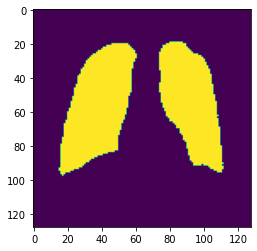

In [103]:
plt.imshow(to_img_gen(X_test[1],loaded_model))
plt.show()

### Instantiating the model again, compiling it, and training it on more epochs:

In [78]:
unet_model = unet()

In [79]:
unet_model.compile(optimizer='adam',
                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=['accuracy'])

In [85]:
TRAIN_LENGTH = len(X_train)
EPOCHS = 15
VAL_SUBSPLITS = 5
BATCH_SIZE = 20
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
model_history = unet_model.fit(X_train,Y_train ,epochs=EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps = VALIDATION_STEPS,
                               validation_data=(X_test, Y_test))

Epoch 1/15
7/7 [==============================] - 34s 5s/step - loss: 0.1489 - accuracy: 0.9366
Epoch 2/15
7/7 [==============================] - 34s 5s/step - loss: 0.1421 - accuracy: 0.9399
Epoch 3/15
7/7 [==============================] - 35s 5s/step - loss: 0.1621 - accuracy: 0.9311
Epoch 4/15
7/7 [==============================] - 36s 5s/step - loss: 0.1402 - accuracy: 0.9418
Epoch 5/15
7/7 [==============================] - 35s 5s/step - loss: 0.1217 - accuracy: 0.9489
Epoch 6/15
7/7 [==============================] - 34s 5s/step - loss: 0.1152 - accuracy: 0.9535
Epoch 7/15
7/7 [==============================] - 36s 5s/step - loss: 0.1067 - accuracy: 0.9560
Epoch 8/15
7/7 [==============================] - 39s 6s/step - loss: 0.0946 - accuracy: 0.9613
Epoch 9/15
7/7 [==============================] - 36s 5s/step - loss: 0.0910 - accuracy: 0.9632
Epoch 10/15
7/7 [==============================] - 37s 5s/step - loss: 0.0916 - accuracy: 0.9627
Epoch 11/15
7/7 [======================

In [89]:
unet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 128, 128, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 32) 9248        conv2d_38[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_39[0][0]                  
____________________________________________________________________________________________

In [90]:
from tensorflow.keras.models import load_model
unet_model.save('2nd_real_OK_unet')  # creates a HDF5 file 'my_model.h5

loaded_model_better = tf.keras.models.load_model('2nd_real_OK_unet')

INFO:tensorflow:Assets written to: 2nd_real_OK_unet/assets


### Defining a unet-model, instantiating, compiling it, and training it --- designed to act on greyscale images:

In [226]:
def unet_grey(input_size=(IMG_HEIGHT, IMG_WIDTH, 1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [160]:
X_train_grey = np.array([tf.image.rgb_to_grayscale(image) for image in X_train])
X_test_grey = np.array([tf.image.rgb_to_grayscale(image) for image in X_test])

In [162]:
print(X_train_grey.shape)
print(X_test_grey.shape)

(140, 128, 128, 1)
(60, 128, 128, 1)


In [165]:
unet_model_grey = unet_grey()

In [166]:
unet_model_grey.compile(optimizer='adam',
                        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                        metrics=['accuracy'])

In [203]:
TRAIN_LENGTH = len(X_train)
EPOCHS = 30
VAL_SUBSPLITS = 5
BATCH_SIZE = 20
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
model_history = unet_model_grey.fit(X_train_grey,Y_train ,epochs=EPOCHS,
                                    steps_per_epoch=STEPS_PER_EPOCH,
                                    validation_steps = VALIDATION_STEPS,
                                    validation_data=(X_test_grey, Y_test))

Epoch 1/30
7/7 [==============================] - 45s 6s/step - loss: 0.1058 - accuracy: 0.9571
Epoch 2/30
7/7 [==============================] - 40s 6s/step - loss: 0.1003 - accuracy: 0.9600
Epoch 3/30
7/7 [==============================] - 59s 9s/step - loss: 0.0946 - accuracy: 0.9620
Epoch 4/30
7/7 [==============================] - 41s 6s/step - loss: 0.0861 - accuracy: 0.9660
Epoch 5/30
7/7 [==============================] - 40s 6s/step - loss: 0.0831 - accuracy: 0.9671
Epoch 6/30
7/7 [==============================] - 41s 6s/step - loss: 0.0791 - accuracy: 0.9689
Epoch 7/30
7/7 [==============================] - 39s 6s/step - loss: 0.0798 - accuracy: 0.9685
Epoch 8/30
7/7 [==============================] - 39s 6s/step - loss: 0.0865 - accuracy: 0.9646
Epoch 9/30
7/7 [==============================] - 41s 6s/step - loss: 0.1291 - accuracy: 0.9491
Epoch 10/30
7/7 [==============================] - 39s 6s/step - loss: 0.0940 - accuracy: 0.9618
Epoch 11/30
7/7 [======================

In [205]:
from tensorflow.keras.models import load_model
unet_model_grey.save('grayscale_unet')  # creates a HDF5 file 'my_model.h5'
loaded_unet_grey = tf.keras.models.load_model('grayscale_unet')

INFO:tensorflow:Assets written to: grayscale_unet/assets


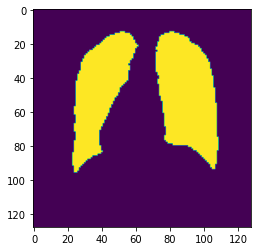

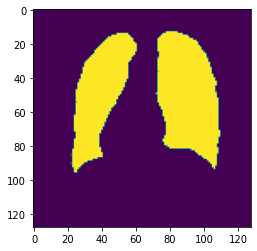

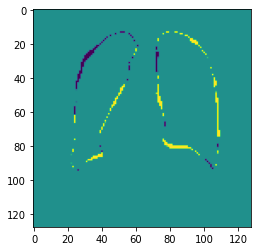

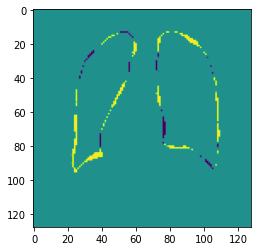

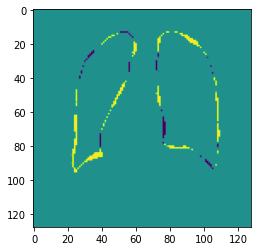

In [212]:
plt.imshow(to_img_gen(X_test_grey[2], desired_model=loaded_unet_grey, lung_threshold=1/2, channels=1))
plt.show()

plt.imshow(Y_test[2])
plt.show()

plt.imshow(Y_test[2]-to_img_gen(X_test_grey[2], desired_model=loaded_unet_grey, lung_threshold=1/2, channels=1))
plt.show()

plt.imshow(Y_test[2]-to_img_gen(X_test[2], desired_model=loaded_model_better, lung_threshold=1/2, channels=3))
plt.show()

plt.imshow(Y_test[2]-to_img_gen(X_test[2], lung_threshold=1/2, channels=3))
plt.show()

### Doing a greyscale model with F1-like metrics <https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2>:

In [235]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = np.sum(y_true * y_pred, axis=[1,2,3])
    union = np.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = np.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [236]:
unet_grey_second = unet_grey()

In [373]:
test_numpy_arr = np.array([1,2,3])

metric = tfa.metrics.F1Score(num_classes=2, threshold=0.5)
y_true = np.array([[1, 1],
                   [11, 1]], np.int32)
y_pred = np.array([[0.6, 0.6],
                   [0.6, 0.0]], np.float32)
metric.update_state(y_true, y_pred)
result = metric.result()
result.numpy()

array([1.7142857, 0.6666667], dtype=float32)

In [386]:
unet_grey_second.compile(optimizer=Adam(lr=1e-5), 
                         loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                         metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

# unet_grey_second.compile(optimizer=Adam(lr=1e-5), 
#                          loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
#                          metrics=[tfa.metrics.F1Score(num_classes=2, average="macro")])


In [387]:
TRAIN_LENGTH = len(X_train)
EPOCHS = 10
VAL_SUBSPLITS = 5
BATCH_SIZE = 20
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
model_history = unet_grey_second.fit(X_train_grey,Y_train ,epochs=EPOCHS,
                                     steps_per_epoch=STEPS_PER_EPOCH,
                                     validation_steps = VALIDATION_STEPS,
                                     validation_data=(X_test_grey, Y_test))

Epoch 1/10
7/7 [==============================] - 36s 5s/step - loss: 0.3703 - mean_io_u_4: 0.3794
Epoch 2/10
7/7 [==============================] - 34s 5s/step - loss: 0.3775 - mean_io_u_4: 0.3746
Epoch 3/10
7/7 [==============================] - 35s 5s/step - loss: 0.3678 - mean_io_u_4: 0.3781
Epoch 4/10
7/7 [==============================] - 35s 5s/step - loss: 0.3661 - mean_io_u_4: 0.3771
Epoch 5/10
7/7 [==============================] - 34s 5s/step - loss: 0.3710 - mean_io_u_4: 0.3735
Epoch 6/10
7/7 [==============================] - 35s 5s/step - loss: 0.3598 - mean_io_u_4: 0.3781
Epoch 7/10
7/7 [==============================] - 36s 5s/step - loss: 0.3577 - mean_io_u_4: 0.3785
Epoch 8/10
7/7 [==============================] - 36s 5s/step - loss: 0.3613 - mean_io_u_4: 0.3746
Epoch 9/10
7/7 [==============================] - 35s 5s/step - loss: 0.3527 - mean_io_u_4: 0.3785
Epoch 10/10
7/7 [==============================] - 46s 7s/step - loss: 0.3471 - mean_io_u_4: 0.3807


1.0
0.0
0.50891113


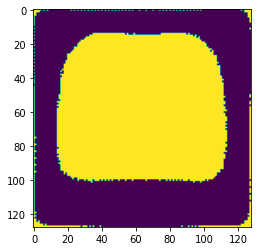

In [392]:
qwantz = to_img_gen(X_test_grey[2], desired_model=unet_grey_second, lung_threshold=9/10, channels=1)
print(qwantz.max())
print(qwantz.min())
print(qwantz.mean())
plt.imshow(to_img_gen(X_test_grey[2], desired_model=unet_grey_second, lung_threshold=9/10, channels=1))
plt.show()

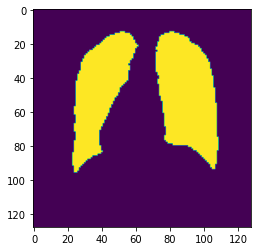

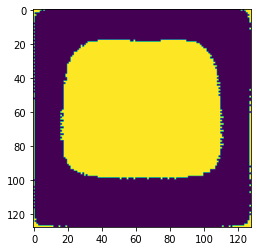

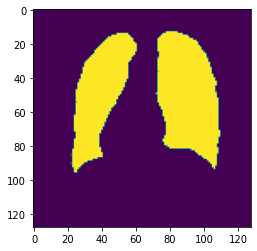

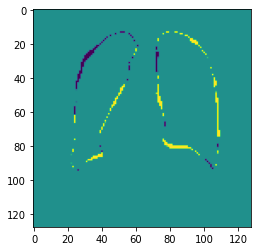

In [385]:
plt.imshow(to_img_gen(X_test_grey[2], desired_model=loaded_unet_grey, lung_threshold=1/2, channels=1))
plt.show()

plt.imshow(to_img_gen(X_test_grey[2], desired_model=unet_grey_second, lung_threshold=8/10, channels=1))
plt.show()

plt.imshow(Y_test[2])
plt.show()

plt.imshow(Y_test[2]-to_img_gen(X_test_grey[2], desired_model=loaded_unet_grey, lung_threshold=1/2, channels=1))
plt.show()



### Printing the image-outputs:

In [174]:
def to_img_gen(lung_xray, desired_model=unet_model, lung_threshold=1/2, channels=3):
#     width, height = lung_xray.shape[0], lung_xray.shape[1]
    lung_xray = np.resize(lung_xray, (lung_xray.shape[0], lung_xray.shape[1], channels))
    pred_lung = (1+np.sign(\
                           desired_model.predict(lung_xray[tf.newaxis, ...]).squeeze()-(1-lung_threshold)\
                          )\
                )/2
    pred_lung = np.resize(pred_lung, (pred_lung.shape[0], pred_lung.shape[1], 1))
#     pred_lung = np.resize(pred_lung, (width, height, 1))
    return pred_lung

In [154]:
print(type(to_img_gen(X_test[1])))
print(to_img_gen(X_test[1]).max())
print(to_img_gen(X_test[1]).min())
print(to_img_gen(X_test[1]).shape)

<class 'numpy.ndarray'>
1.0
0.0
(128, 128, 1)


In [141]:
print(to_img_gen(X_test[1], loaded_model_better).max())
print(to_img_gen(X_test[1], loaded_model_better).min())
print(to_img_gen(X_test[1], loaded_model_better).mean())
print(type(to_img_gen(X_test[1], loaded_model_better)))
print(to_img_gen(X_test[1], loaded_model_better).shape)

1.0
0.0
0.25286865
<class 'numpy.ndarray'>
(128, 128, 1)


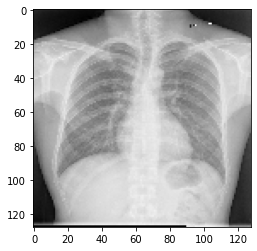

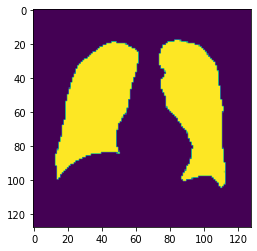

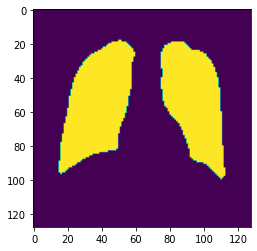

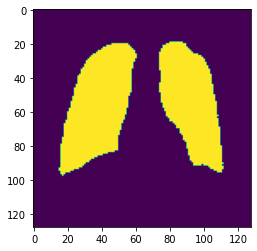

In [157]:
plt.imshow(X_test[1])
plt.show()

plt.imshow(Y_test[1])
plt.show()

plt.imshow(to_img_gen(X_test[1], loaded_model_better, 5/10))
plt.show()

plt.imshow(to_img_gen(X_test[1], loaded_model, 5/10))
plt.show()

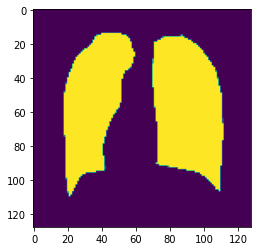

Difference between human-gen mask and model-gen mask with threshold = 11


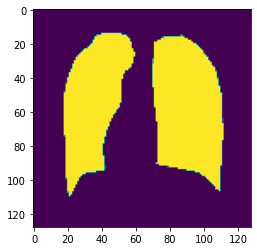

Difference between human-gen mask and model-gen mask with threshold = 0.9


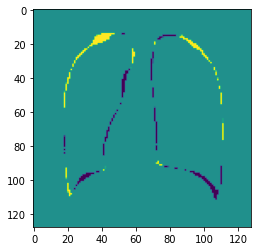

Difference between human-gen mask and model-gen mask with threshold = 0.8


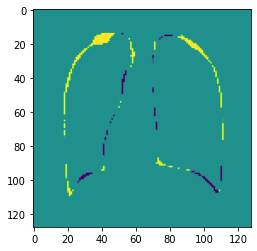

Difference between human-gen mask and model-gen mask with threshold = 0.5


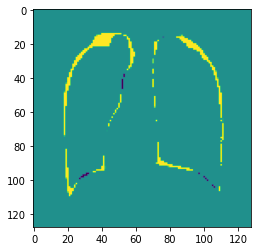

Difference between human-gen mask and model-gen mask with threshold = 0.2


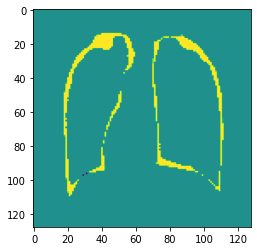

In [155]:
plt.imshow(Y_train[35])
plt.show()

theshold = 11
print(f"Difference between human-gen mask and model-gen mask with threshold = {theshold}")
plt.imshow(Y_train[35]-to_img_gen(X_train[35], loaded_model_better, theshold))
plt.show()

theshold = 9/10
print(f"Difference between human-gen mask and model-gen mask with threshold = {theshold}")
plt.imshow(Y_train[35]-to_img_gen(X_train[35], loaded_model_better, theshold))
plt.show()

theshold = 8/10
print(f"Difference between human-gen mask and model-gen mask with threshold = {theshold}")
plt.imshow(Y_train[35]-to_img_gen(X_train[35], loaded_model_better, theshold))
plt.show()

theshold = 5/10
print(f"Difference between human-gen mask and model-gen mask with threshold = {theshold}")
plt.imshow(Y_train[35]-to_img_gen(X_train[35], loaded_model_better, theshold))
plt.show()

theshold = 2/10
print(f"Difference between human-gen mask and model-gen mask with threshold = {theshold}")
plt.imshow(Y_train[35]-to_img_gen(X_train[35], loaded_model_better, theshold))
plt.show()

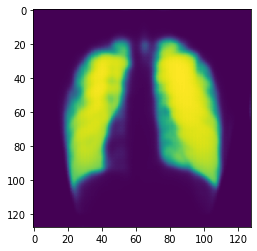

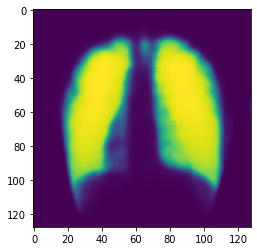

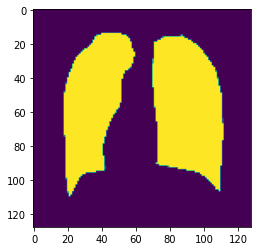

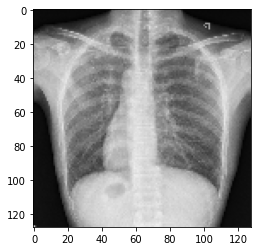

In [88]:
plt.imshow(to_img_gen(X_train[35]))
plt.show()

plt.imshow(to_img_gen(X_train[35], loaded_model))
plt.show()

plt.imshow(Y_train[35])
plt.show()

plt.imshow(X_train[35])
plt.show()

## computing 1+1 = 2

In [17]:
1+1

2

In [248]:
x = [[[1.0, 2.0, 3.0],
      [4.0, 5.0, 6.0]],
    [[7.0, 8.0, 9.0],
      [10.0, 11.0, 12.0]]]
tf.image.adjust_contrast(x, 20000)

<tf.Tensor: shape=(2, 2, 3), dtype=float32, numpy=
array([[[-89994.5, -89993.5, -89992.5],
        [-29994.5, -29993.5, -29992.5]],

       [[ 30005.5,  30006.5,  30007.5],
        [ 90005.5,  90006.5,  90007.5]]], dtype=float32)>

In [251]:
nums = np.array([1,4, 43])
nums*3

array([  3,  12, 129])

In [324]:
from tensorflow.keras import layers

IMG_SIZE = 1280

resize = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)#,
])

resize_and_rotate = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.RandomRotation(0.04),
])

def ims(img):
    plotted = plt.imshow(img)
    plt.show()
    return plotted

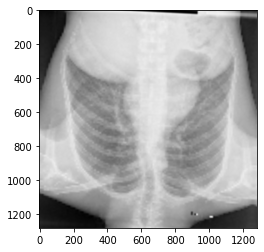

In [350]:
# Y_r = np.array(resize(Y_test[1]))
# X_r = np.array(resize(X_test[1]))[0]/255

# Y_rr = resize_and_rotate(np.array(Y_test[1]))
X_rr = data_augmentation(np.array([X_test[1]]))[0]

ims(X_rr)
# ims(Y_rr-Y_r)

# ims(X_test[1] - X_test[1])
# ims(Y_test[1] - Y_test[1])

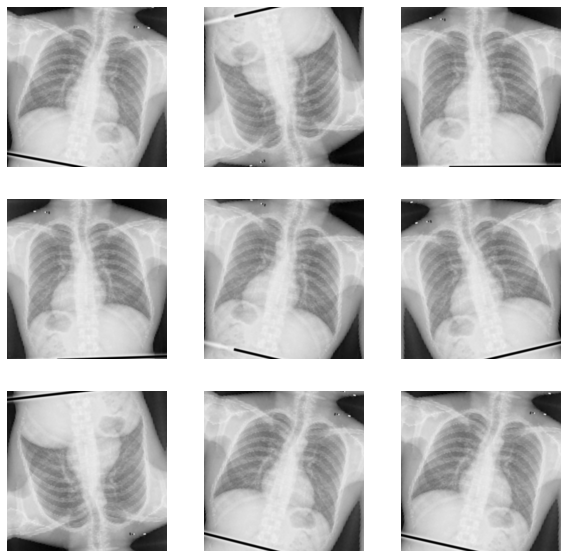

In [334]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.RandomRotation(0.04),
])

plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(np.array([X_test[1]]))
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

In [305]:
import tensorflow_addons as tfa

In [308]:
from tensorflow_addons.metrics import F1Score

## (s)crap

In [189]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, concatenate,\
        UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model

In [200]:
def initialize_unet(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    print('Initializing model...')

    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    unet = Model(inputs=[inputs], outputs=[conv10])


        # unet = Sequential()
        # inputs = Input(input_size)

        # unet.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
        # unet.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
        # unet.add(MaxPooling2D(pool_size=(2, 2)))

        # unet.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
        # unet.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
        # unet.add(MaxPooling2D(pool_size=(2, 2)))

        # unet.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
        # unet.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
        # unet.add(MaxPooling2D(pool_size=(2, 2)))

        # unet.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
        # unet.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
        # unet.add(MaxPooling2D(pool_size=(2, 2)))

        # unet.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
        # unet.add(Conv2D(512, (3, 3), activation='relu', padding='same'))

        # unet.add(concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3))
        # unet.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
        # unet.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

        # unet.add(concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3))
        # unet.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
        # unet.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

        # unet.add(concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3))
        # unet.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
        # unet.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

        # unet.add(concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3))
        # unet.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
        # unet.add(Conv2D(32, (3, 3), activation='relu', padding='same'))

        # unet.add(Conv2D(1, (1, 1), activation='sigmoid'))

    unet.compile(Adam(lr=0.001),
                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 metrics=['accuracy'])

        # my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
        #                                                  mode='min',
        #                                                  patience=10)]


    return unet

In [201]:
test_model = initialize_unet()

Initializing model...


In [ ]:
#     my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                          mode='min',
#                                                          patience=10)]